In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns;
import numpy as np
import pandas as pd

# Why use Manifold Learning?
PCA is good at reducing the dimensionality, but it sucks when the data has nonlinear relationships within it.

To fix this problem we can use a class of methods known as Manifold Learning - a class of unsupervised estimators that seeks to describe datasets as low-dimensional manifolds embedded in high-dimensional spaces. When you think of a manifold, I'd suggest imagining a sheet of paper: this is a two-dimensional object that lives in our familiar three-dimensional world, and can be bent or rolled in that two dimensions. In the parlance of manifold learning, we can think of this sheet as a two-dimensional manifold embedded in three-dimensional space.

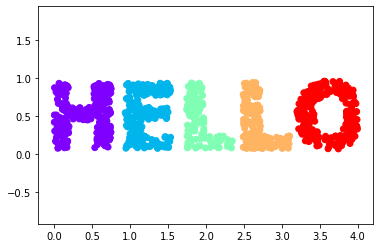

In [2]:
# создадим двумерные данные
def make_hello(N=1000, rseed=42):
    # Make a plot with "HELLO" text; save as PNG
    fig, ax = plt.subplots(figsize=(4, 1))
    fig.subplots_adjust(left=0, right=1, bottom=0, top=1)
    ax.axis('off')
    ax.text(0.5, 0.4, 'HELLO', va='center', ha='center', weight='bold', size=85)
    fig.savefig('hello.png')
    plt.close(fig)
    
    # Open this PNG and draw random points from it
    from matplotlib.image import imread
    data = imread('hello.png')[::-1, :, 0].T
    rng = np.random.RandomState(rseed)
    X = rng.rand(4 * N, 2)
    i, j = (X * data.shape).astype(int).T
    mask = (data[i, j] < 1)
    X = X[mask]
    X[:, 0] *= (data.shape[0] / data.shape[1])
    X = X[:N]
    return X[np.argsort(X[:, 0])]

X = make_hello(1000)
colorize = dict(c=X[:, 0], cmap=plt.cm.get_cmap('rainbow', 5))
plt.scatter(X[:, 0], X[:, 1], **colorize)
plt.axis('equal');

# MDS - Multidimentional Scaling

Looking at data like this, we can see that the particular choice of x and y values of the dataset are not the most fundamental description of the data: we can scale, shrink, or rotate the data, and the "HELLO" will still be apparent. For example, if we use a rotation matrix to rotate the data, the x and y values change, but the data is still fundamentally the same:

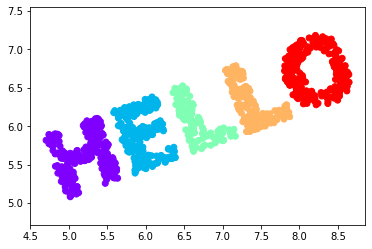

In [3]:
def rotate(X, angle):
    theta = np.deg2rad(angle)
    R = [[np.cos(theta), np.sin(theta)],
         [-np.sin(theta), np.cos(theta)]]
    return np.dot(X, R)
    
X2 = rotate(X, 20) + 5
plt.scatter(X2[:, 0], X2[:, 1], **colorize)
plt.axis('equal');

# конкретные значения x и y неважны, важные расстояния между х и y 

D == D2:  True


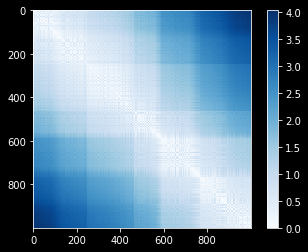

In [4]:
# визуализируем расстояния между точками через .pairwise_distances, строящую матрицу N на N
# где N=числу точек, а в ячейках матрицы лежат расстояния между соотв. точками
from sklearn.metrics import pairwise_distances
D = pairwise_distances(X)

# визуализация матрицы
plt.style.use('dark_background')
plt.imshow(D, zorder=2, cmap='Blues', interpolation='nearest')
plt.colorbar();

# заодно проверим будут ли равны матрицы для исходной картинки и повёрнутой
D2 = pairwise_distances(X2)
print('D == D2: ', np.allclose(D, D2))

This distance matrix gives us a representation of our data that is invariant to rotations and translations, but the visualization of the matrix above is not entirely intuitive (ничего не понятно, слова HELLO на ней нет и в помине).

Создать матрицу расстояний легко, а вот трансформировать её обратно в x и y координаты сложно. Это и делает MDS - given a distance matrix between points, it recovers a $D$-dimensional coordinate representation of the data.

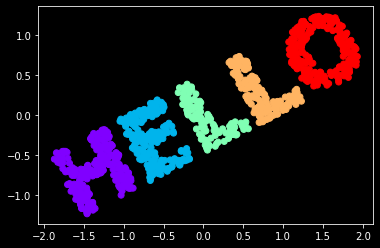

In [5]:
# востановим исходный вид данных (двумерный вид)
from sklearn.manifold import MDS
model = MDS(n_components=2, dissimilarity='precomputed', random_state=1)
out = model.fit_transform(D)
plt.scatter(out[:, 0], out[:, 1], **colorize)
plt.axis('equal');

MDS algorithm recovers one of the possible two-dimensional coordinate representations of our data, using only the $N\times N$ distance matrix describing the relationship between the data points

Важный момент - матрицу расстояний можно построить из данных ЛЮБОЙ размерности и затем получить из неё "версию" этих данных с МЕНЬШЕЙ размерностью.

Пример преобразования 2D -> 3D -> 2D, с использованием MDS:

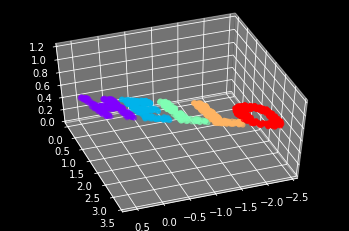

In [6]:
# Преобразуем исходную картинку в 3D
def random_projection(X, dimension=3, rseed=42):
    assert dimension >= X.shape[1]
    rng = np.random.RandomState(rseed)
    C = rng.randn(dimension, dimension)
    e, V = np.linalg.eigh(np.dot(C, C.T))
    return np.dot(X, V[:X.shape[1]])
X3 = random_projection(X, 3)

# визуализируем результат преобразования
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(X3[:, 0], X3[:, 1], X3[:, 2],
             **colorize)
ax.view_init(azim=70, elev=50)

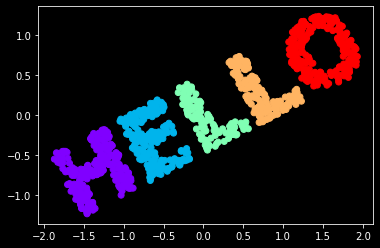

In [7]:
# применим MDS
model = MDS(n_components=2, random_state=1)
out3 = model.fit_transform(X3)
plt.scatter(out3[:, 0], out3[:, 1], **colorize)
plt.axis('equal');

# Manifold Learning Goal:
Given high-dimensional embedded data, it seeks a low-dimensional representation of the data that preserves certain relationships within the data.

In the case of MDS, the quantity preserved is the distance between every pair of points.

# Nonlinear Embeddings: Where MDS Fails

MDS отлично работает с линейными преобразованиями (вращения, изменение размера, т.д.) однако при нелинейных преобразованиях он лажает.

Пример - трансформируем исходную картинку в форму буквы S и затем скормим её MDSу.

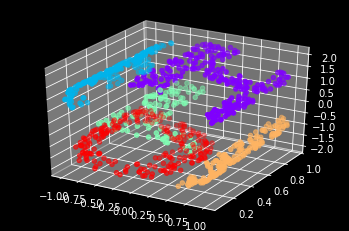

In [8]:
def make_hello_s_curve(X):
    t = (X[:, 0] - 2) * 0.75 * np.pi
    x = np.sin(t)
    y = X[:, 1]
    z = np.sign(t) * (np.cos(t) - 1)
    return np.vstack((x, y, z)).T

XS = make_hello_s_curve(X)

from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize);

# важно - исходные "отношения" между точками всё ещё остались здесь,
# однако трансформация была произведенна нелинейная

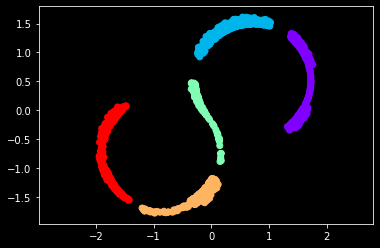

In [9]:
# применим MDS к нелинейно трансформированным данным
from sklearn.manifold import MDS
model = MDS(n_components=2, random_state=2)
outS = model.fit_transform(XS)
plt.scatter(outS[:, 0], outS[:, 1], **colorize)
plt.axis('equal');

MDS не смог восстановить исходные данные из нелинейно-трансформированных. Он просто отбросил ось Y, что является ошибкой.

Причина в том, что MDS пытается сохранить расстояния между всеми парами точек. Однако если мы изменим его алгоритм так, чтобы он сохранял только расстояния между ближайшими точками то результат будет гораздо лучше. Такой алгоритм уже есть, и называется от locally linear embedding 

# LLE - locally linear embedding 

It instead tries to preserve only the distances between neighboring points. LLE comes in a number of flavors.

Here we will use the modified LLE algorithm to recover the embedded two-dimensional manifold. In general, modified LLE does better than other flavors of the algorithm at recovering well-defined manifolds with very little distortion:

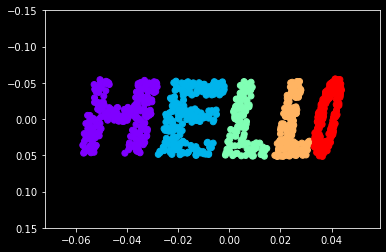

In [10]:
# применим LLE к нелинейно изменённым данным
from sklearn.manifold import LocallyLinearEmbedding
model = LocallyLinearEmbedding(n_neighbors=100, n_components=2, method='modified',
                               eigen_solver='dense')
out = model.fit_transform(XS)

fig, ax = plt.subplots()
ax.scatter(out[:, 0], out[:, 1], **colorize)
ax.set_ylim(0.15, -0.15);

# Summary of Manifold Methods 
Несмотря на все свои плюсы эти алгоритмы в большинстве своём очень карпизны и редко используются для чего-то кроме простых визуализаций данных большой размерности.

#### Их минусы (в сравнении с PCA):

    1) In manifold learning, there is no good framework for handling missing data. In contrast, there are straightforward iterative approaches for missing data in PCA.
    2) In manifold learning, the presence of noise in the data can "short-circuit" the manifold and drastically change the embedding. In contrast, PCA naturally filters noise from the most important components.
    3) The manifold embedding result is generally highly dependent on the number of neighbors chosen, and there is generally no solid quantitative way to choose an optimal number of neighbors. In contrast, PCA does not involve such a choice.
    4) In manifold learning, the globally optimal number of output dimensions is difficult to determine. In contrast, PCA lets you find the output dimension based on the explained variance
    5) In manifold learning, the meaning of the embedded dimensions is not always clear. In PCA, the principal components have a very clear meaning.
    6) In manifold learning the computational expense of manifold methods scales as O[N^2] or O[N^3]. For PCA, there exist randomized approaches that are generally much faster (though see the megaman package for some more scalable implementations of manifold learning).

Из-за этих недостатков и единственного плюса - возможности сохранять нелинейные отношения в данных имеет смысл использовать Manifold Learning Methods только после исследования данных с помошью РСА (т.е. manifold будет как дополнительное исследование).

# Краткий гайд по выбору Manifold Learning Method:

    1) Для простых задач (типо нашего S-преобразования) locally linear embedding (LLE) and its variants (especially modified LLE), perform very well. This is implemented in sklearn.manifold.LocallyLinearEmbedding.
    
    2) For high-dimensional data from real-world sources, LLE often produces poor results, and isometric mapping (IsoMap) seems to generally lead to more meaningful embeddings. This is implemented in sklearn.manifold.Isomap
    
    3) For data that is highly clustered, t-distributed stochastic neighbor embedding (t-SNE) seems to work very well, though can be very slow compared to other methods. This is implemented in sklearn.manifold.TSNE.

# Пример - Isomap

Manifold Learning чаще всего используется для понимания отношений между high-dimensional data points. A common case of high-dimensional data is images: for example, a set of images with 1,000 pixels each can be thought of as a collection of points in 1,000 dimensions – the brightness of each pixel in each image defines the coordinate in that dimension.

В этом примере мы используем Isomap на сете с лицами политиков.

In [11]:
from sklearn.datasets import fetch_lfw_people
faces = fetch_lfw_people(min_faces_per_person=30)
faces.data.shape

# we have 1701 images, each with 2,914 pixels. So our data points is in the 2914-dimentional space

(1701, 2914)

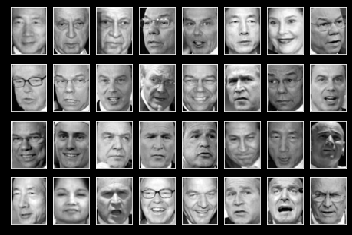

In [12]:
fig, ax = plt.subplots(4, 8, subplot_kw=dict(xticks=[], yticks=[]))
for i, axi in enumerate(ax.flat):
    axi.imshow(faces.images[i], cmap='gray')

We would like to plot a low-dimensional embedding of the 2,914-dimensional data to learn the fundamental relationships between the images. One useful way to start is to compute a PCA, and examine the explained variance ratio, which will give us an idea of how many linear features are required to describe the data:

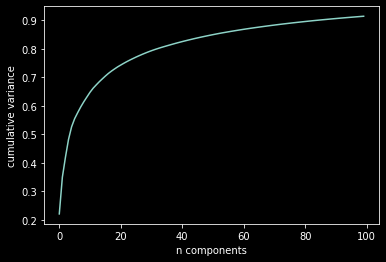

In [13]:
from sklearn.decomposition import PCA
model = PCA(100).fit(faces.data)
plt.plot(np.cumsum(model.explained_variance_ratio_))
plt.xlabel('n components')
plt.ylabel('cumulative variance');

We see that for this data, nearly 100 components are required to preserve 90% of the variance: this tells us that the data is intrinsically very high dimensional—it can't be described linearly with just a few components.

When this is the case, nonlinear manifold embeddings like LLE and Isomap can be helpful. We can compute an Isomap embedding on these faces using the same pattern shown before:


In [14]:
from sklearn.manifold import Isomap
model = Isomap(n_components=2)
proj = model.fit_transform(faces.data)
proj.shape

(1701, 2)

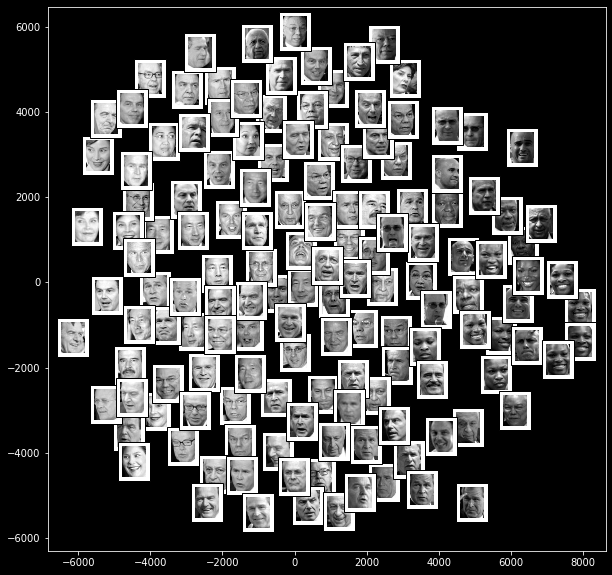

In [15]:
# функция выводка маленьких картинок рядом с точками получеными от РСА
from matplotlib import offsetbox

def plot_components(data, model, images=None, ax=None,
                    thumb_frac=0.05, cmap='gray'):
    ax = ax or plt.gca()
    
    proj = model.fit_transform(data)
    ax.plot(proj[:, 0], proj[:, 1], '.k')
    
    if images is not None:
        min_dist_2 = (thumb_frac * max(proj.max(0) - proj.min(0))) ** 2
        shown_images = np.array([2 * proj.max(0)])
        for i in range(data.shape[0]):
            dist = np.sum((proj[i] - shown_images) ** 2, 1)
            if np.min(dist) < min_dist_2:
                # don't show points that are too close
                continue
            shown_images = np.vstack([shown_images, proj[i]])
            imagebox = offsetbox.AnnotationBbox(
                offsetbox.OffsetImage(images[i], cmap=cmap),
                                      proj[i])
            ax.add_artist(imagebox)
            
# вызов этой функции            
fig, ax = plt.subplots(figsize=(10, 10))
plot_components(faces.data,
                model=Isomap(n_components=2),
                images=faces.images[:, ::2, ::2])

The result is interesting: the first two Isomap dimensions seem to describe global image features: the overall darkness or lightness of the image from left to right, and the general orientation of the face from bottom to top. This gives us a nice visual indication of some of the fundamental features in our data.